In [185]:
import linsolve
import tf_linsolve
import tensorflow as tf
import scipy
import numpy as np
import pylab as plt
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Methods

Here, I'll develop some methods to replace the solvers in linsolve assuming that the inputs are tensors

### Solvers Dense

In [44]:
# This could help with repeated calls, but increases the runtime for single usage
#@tf.function
def _invert_lsqr(A, y, rcond=0, sparse=False):
    """
    
    rcond: 
        rcond must be set to 0 to work for complex datasets
    """
    dtype = y.dtype
    assert not (
        dtype in [np.complex128, np.complex64, complex] and rcond > 0
    ), "If using complex data, rcond must be equal to 0 for performance reasons"

    x = tf.linalg.lstsq(
        tf.transpose(A, perm=[2, 0, 1]),
        tf.transpose(y)[..., None],
        l2_regularizer=rcond,
    )[..., 0]
    return x

def _invert_lsqr_sparse(xs_ys_vals, y, rcond):
    """
    """
    A = _get_A_sparse(xs_ys_vals)
    return _invert_lsqr(A, y, rcond, sparse=True)

# This could help with repeated calls, but increases the runtime for single usage
#@tf.function
def _invert_pinv(A, y, rcond, sparse=False):
    """
    """
    dtype = y.dtype
    A = tf.transpose(A, perm=[2, 0, 1])
    AtA = tf.matmul(A, A, adjoint_a=True, a_is_sparse=sparse, b_is_sparse=sparse)

    if dtype in [complex, np.complex64, np.complex128]:
        # tensorflow does not allow for complex psuedo-inverses. Compute the value manually
        R = tf.math.real(AtA)
        C = tf.math.imag(AtA)
        r0 = tf.matmul(tf.linalg.pinv(R), C)
        y11 = tf.linalg.pinv(tf.matmul(C, r0) + R)
        y10 = tf.matmul(-r0, y11)
        AtAi = tf.cast(tf.complex(y11, y10), dtype=AtA.dtype)

    else:
        AtAi = tf.linalg.pinv(AtA, rcond=rcond)

    return tf.einsum(
        "nij,njk,kn->ni", AtAi, tf.transpose(A, perm=[0, 2, 1], conjugate=True), y
    )


def _invert_pinv_sparse(xs_ys_vals, y, rcond):
    """
    """
    A = _get_A_sparse(xs_ys_vals)
    return _invert_pinv(A, y, rcond, sparse=True)

# This could help with repeated calls, but increases the runtime for single usage
#@tf.function
def _invert_solve(A, y, rcond, sparse=False):
    """
    """
    A = tf.transpose(A, perm=[2, 0, 1])
    AtA = tf.matmul(A, A, adjoint_a=True, a_is_sparse=sparse, b_is_sparse=sparse)
    Aty = tf.matmul(
        tf.transpose(A, perm=[0, 2, 1], conjugate=True),
        tf.transpose(y)[..., None],
        a_is_sparse=sparse,
    )
    return tf.linalg.solve(AtA, Aty)[..., 0]

def _invert_solve_sparse(xs_ys_vals, y, rcond):
    """
    """
    A = _get_A_sparse(xs_ys_vals)
    return _invert_solve(A, y, rcond, sparse=True)

# This could help with repeated calls, but increases the runtime for single usage
#@tf.function
def _invert_pinv_shared(A, y, rcond, sparse=False):
    """
    """
    AtA = tf.matmul(A, A, adjoint_a=True, a_is_sparse=sparse, b_is_sparse=sparse)
    dtype = AtA.dtype

    if dtype in [complex, np.complex64, np.complex128]:
        # tensorflow does not allow for complex psuedo-inverses. Compute the value manually
        R = tf.math.real(AtA)
        C = tf.math.imag(AtA)
        r0 = tf.matmul(tf.linalg.pinv(R), C)
        y11 = tf.linalg.pinv(tf.matmul(C, r0) + R)
        y10 = tf.matmul(-r0, y11)
        AtAi = tf.cast(tf.complex(y11, y10), dtype=AtA.dtype)

    else:
        AtAi = tf.linalg.pinv(AtA, rcond=rcond)
        
    return tf.transpose(tf.matmul(AtAi, tf.matmul(A, y, adjoint_a=True, a_is_sparse=sparse)))

def _invert_pinv_shared_sparse(xs_ys_vals, y, rcond):
    """
    """
    A = _get_A_sparse(xs_ys_vals)
    return _invert_pinv_shared(A, y, rcond, sparse=True)

In [55]:
tf.convert_to_tensor?

### Helper Methods

In [45]:
def _get_AtA_Aty_sparse(xs_ys_vals, y):
    """
    """
    pass

## Standard Linsolve

### Standard Linsolve Case

In [35]:
x = np.linspace(0, 2 * np.pi, 1000)
g = np.cos(x) + 1j * np.sin(x)
h = np.sin(x) + 1j * np.cos(x)
i = x + 1j * x
data = {'g + h': g + h, 'g + i': g + i, 'i + h': i + h, 'i + g + h': i + g + h}
wgts = {k: np.random.uniform(0.9, 1.1, v.shape[0]) for k, v in data.items()}

In [36]:
ls = linsolve.LinearSolver(data)

In [37]:
A = ls.get_A()[..., 0]
y = ls.get_weighted_data()

In [38]:
ATF = tf.convert_to_tensor(A)
yTF = tf.constant(y)

In [39]:
%time ma = _invert_pinv_shared(ATF, yTF, rcond=None)

CPU times: user 2.84 ms, sys: 1.46 ms, total: 4.3 ms
Wall time: 2.94 ms


In [40]:
%time s = ls.solve()

CPU times: user 2.9 ms, sys: 2.92 ms, total: 5.82 ms
Wall time: 1.75 ms


#### Profile

In [41]:
%lprun -f _invert_pinv_shared _invert_pinv_shared(ATF, yTF, rcond=None)

### Least-Squares Case

In [46]:
ls = linsolve.LinearSolver(data, wgts=wgts)
ATF = tf.convert_to_tensor(ls.get_A())
yTF = tf.convert_to_tensor(ls.get_weighted_data())

In [53]:
%time sol = _invert_lsqr(ATF, yTF, rcond=0)

CPU times: user 3.62 ms, sys: 1.27 ms, total: 4.89 ms
Wall time: 2.43 ms


In [54]:
%time solution = ls.solve(mode='lsqr')

CPU times: user 40.5 ms, sys: 5.64 ms, total: 46.1 ms
Wall time: 41.3 ms


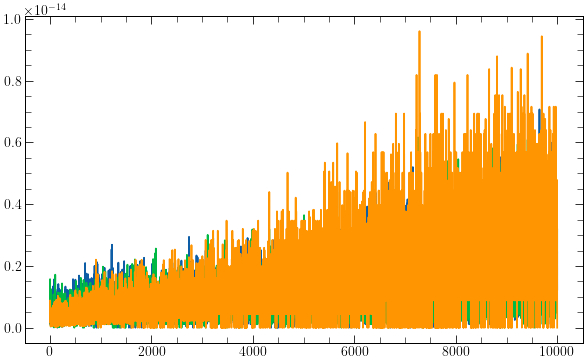

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(np.abs(solution['g'] - sol[..., 0]))
plt.plot(np.abs(solution['h'] - sol[..., 1]))
plt.plot(np.abs(solution['i'] - sol[..., 2]))
plt.show()

#### Profiling

In [90]:
%lprun -f _invert_lsqr _invert_lsqr(ATF, yTF, rcond=0)

### Psuedo-inverse

In [91]:
%time solution = _invert_pinv(ATF, yTF, rcond=None)

CPU times: user 139 ms, sys: 19 ms, total: 158 ms
Wall time: 25.1 ms


In [92]:
%time sol = ls.solve()

CPU times: user 196 ms, sys: 34.7 ms, total: 231 ms
Wall time: 74.8 ms


#### Profiling

In [93]:
%lprun -f _invert_pinv _invert_pinv(ATF, yTF, rcond=None)

### Solve

In [94]:
%time _ = _invert_solve(ATF, yTF, 0)

CPU times: user 37.6 ms, sys: 2 ms, total: 39.6 ms
Wall time: 7.94 ms


In [95]:
%time sol = ls.solve(mode='solve')

CPU times: user 72.1 ms, sys: 5.21 ms, total: 77.3 ms
Wall time: 76.3 ms


#### Profiling

In [75]:
%lprun -f _invert_solve _invert_solve(ATF, yTF, rcond=None)

# Tensorflow Operations

In [64]:
A = np.random.uniform(0, 1, size=(200, 100, 300)) + 1j * np.random.uniform(0, 1, size=(200, 100, 300))
ATF = tf.complex(tf.random.uniform((200, 100, 300)), tf.random.uniform((200, 100, 300)))

## Conjugation

In [77]:
%%time
_ = A.conj()

CPU times: user 18.3 ms, sys: 4.04 ms, total: 22.3 ms
Wall time: 20.9 ms


In [78]:
%%time
_ = tf.math.conj(ATF)

CPU times: user 54 ms, sys: 7.93 ms, total: 62 ms
Wall time: 12.6 ms


## Transpose

In [101]:
%%time
_ = tf.einsum("ijk...->ikj...", ATF)

CPU times: user 65.5 ms, sys: 943 µs, total: 66.4 ms
Wall time: 6.99 ms


In [102]:
%%time
_ = tf.transpose(ATF, perm=[0, 2, 1])

CPU times: user 66.2 ms, sys: 5.13 ms, total: 71.3 ms
Wall time: 11.6 ms


In [103]:
%%time
_ = tf.reshape(ATF, (200, 300, 100))

CPU times: user 258 µs, sys: 3.44 ms, total: 3.69 ms
Wall time: 3.7 ms


In [104]:
%%time
G = tf.linalg.matrix_transpose(ATF)

CPU times: user 69.2 ms, sys: 6.17 ms, total: 75.4 ms
Wall time: 11.5 ms


In [112]:
G = tf.constant(G)

In [120]:
%%time
_ = tf.einsum('ijk,ijl->ij', G, G)

CPU times: user 39.2 ms, sys: 1.8 ms, total: 41 ms
Wall time: 8.54 ms


In [121]:
%%time
_ = tf.einsum('ijk,ijl->ji', G, G)

CPU times: user 38.5 ms, sys: 6.51 ms, total: 45 ms
Wall time: 8.57 ms


In [124]:
tf.linalg.solve?

In [153]:
A = tf.random.uniform((1000, 100, 100))
y = tf.random.uniform((1000, 100, 20))

In [154]:
%%timeit
_ = tf.linalg.solve(A, y)

18.7 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [155]:
%%timeit
_ = tf.transpose(tf.linalg.solve(A, y))

24.2 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [180]:
@tf.function
def function(A):
    """
    """
    return result(A)

@tf.function
def function_graph(A):
    """
    """
    return result_graph(A)

def function_no_opt(A):
    """
    """
    return result_no_opt(A)

def result(A):
    """
    """
    return tf.matmul(A, A, transpose_a=True)

@tf.function
def result_graph(A):
    """
    """
    return tf.matmul(A, A, transpose_a=True)

def result_no_opt(A):
    """
    """
    return tf.matmul(A, A, transpose_a=True)

In [181]:
A = tf.random.uniform((5000, 1000))

In [182]:
%timeit _ = function(A)

20.3 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [183]:
%timeit _ = function_graph(A)

20.3 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [184]:
%timeit _ = function_no_opt(A)

21.4 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
